## Bernie vs Trump

This is a toy example on how to fine-tune on a classification problem.

We have collected sentences from two US presidential candidates and our task is to know from which person they come from.

In [6]:
from typing import Tuple

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from ignite.engine import (
    Events,
    Engine,
)
from ignite.metrics import Accuracy

import torch
from torch.utils.data import (
    DataLoader,
    TensorDataset
)

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
)

from scipy.special import softmax

from sklearn.model_selection import train_test_split

from data import load_data

pd.set_option('display.max_colwidth', None)

## Read and visualize data

In [7]:
sentences = load_data('data', balance=True)
sentences.sample(5)

,sentence,is_trump
117,We will also address the attacks that are being launched each day against the civil rights and civil liberties of our people.,False
65,"We must see ourselves as part of one nation, one community and one society — regardless of race, gender, religion, sexual orientation, or country of origin.",False
105,"It is time for the American people to stand up and fight for their right to freedom, human dignity and security.",False
7,They are the teachers taking to the streets to make certain that schools are adequately funded and that their students get a quality education.,False
205,"We’re going to win so much — we’re going to win a lot. We’re going to win a lot. We’re going to win so much you’re all going to get sick and tired of winning. You’re going to say oh no, not again. I’m only kidding. You never get tired of winning, right? Never.",True


## Load tokenizer 

In [8]:
pretrained_model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

## Decide token length

In [9]:
trump_token_ids = sentences[sentences.is_trump].sentence.apply(
    lambda x: tokenizer.encode(str(x), add_special_tokens=False)
)

bernie_token_ids = sentences[~sentences.is_trump].sentence.apply(
    lambda x: tokenizer.encode(str(x), add_special_tokens=False)
)

Let's visualize the token length per class.

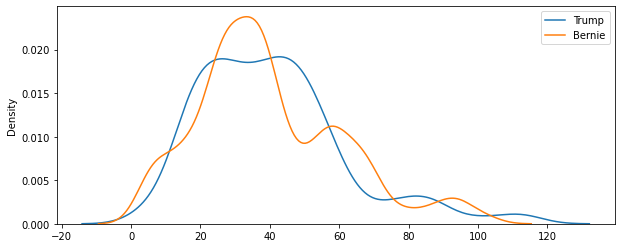

In [10]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

sns.kdeplot(
    list(map(len, trump_token_ids)),
    bw_adjust=0.75,
    label='Trump',
    ax=ax
)

sns.kdeplot(
    list(map(len, bernie_token_ids)),
    bw_adjust=0.55,
    label='Bernie',
    ax=ax,
)

ax.legend()

In [11]:
max_token_num = 70

I am going to limit the length of the sentences to 70.

Let's split data between training and validation.

In [12]:
train_sentences, val_sentences = train_test_split(sentences, test_size=0.18)
print(f'Sentences in training: {len(train_sentences)}')
print(f'Sentences in validation: {len(val_sentences)}')

Sentences in training: 201
Sentences in validation: 45


## Load pre-trained classification model

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False).to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Note warning tells us exactly what we expect to happen before fine-tuning.

## Create data loaders

Let's compute the needed set of arrays to input to BERT.

In [14]:
def encode_sentence(text: str, max_length: int) -> Tuple[np.ndarray, np.ndarray]:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_attention_mask = True
    )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']


def process_data(df: pd.DataFrame,
                 max_length: int) -> Tuple[np.ndarray,
                                           np.ndarray,
                                           np.ndarray]:
    """ Map sentences in DataFrame into proper model inputs
    
    We are extracting, for each sentence:
    
        - List of token identifiers (including special tokens)
        - Input attention masks (which prevent focusing on padding tokens)
        - Sentence label
        
    Number of tokens are padded to the maximum provided (special
    tokens are considered for computing the length of the sentence).
    
    """
    encoded_dicts = df.sentence.apply(
        lambda x: encode_sentence(x, max_length=max_length)
    )
    token_ids, attention_masks = zip(*encoded_dicts)
    return token_ids, attention_masks, df.is_trump.values


def build_dataset(df: pd.DataFrame,
                  max_length: int) -> torch.utils.data.Dataset:
    token_ids, attention_masks, labels = process_data(df,
                                                      max_length=max_length)
    return TensorDataset(torch.Tensor(token_ids).to(torch.long),
                         torch.Tensor(attention_masks),
                         torch.Tensor(labels).to(torch.long))

# As dataset is small, we can fit it on memory
train_dataset = build_dataset(train_sentences, max_length=max_token_num)
val_dataset = build_dataset(val_sentences, max_length=max_token_num)

Create dataset loaders.

In [15]:
batch_size = 32

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

## Set training loop

Initialize optimizer.

In [16]:
optimizer = AdamW(model.parameters(), lr = 1e-5)  # integrated LR decay

Define train step.

In [17]:
def train_step(engine, batch):

    model.train()
    
    optimizer.zero_grad()
    
    batch_token_ids = batch[0].to(device)
    batch_att_masks = batch[1].to(device)
    batch_labels = batch[2].to(device)
    
    loss, _ = model(batch_token_ids,
                    attention_mask=batch_att_masks, 
                    labels=batch_labels)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

Define validation step.

In [18]:
def validation_step(engine, batch):
    
    model.eval()
    
    with torch.no_grad():
        
        batch_token_ids = batch[0].to(device)
        batch_att_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        batch_logits = model(batch_token_ids, attention_mask=batch_att_masks)
        return batch_logits[0], batch_labels

Create trainer and evaluator engines.

In [19]:
trainer = Engine(train_step)

evaluator = Engine(validation_step)
accuracy = Accuracy()
accuracy.attach(evaluator, 'accuracy')

Define callbacks.

In [20]:
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(trainer):
    iteration = trainer.state.iteration
    n_iterations = trainer.state.epoch_length
    print(
        f'Epoch[{trainer.state.epoch}/{trainer.state.max_epochs}] '
        f'Iteration[{(iteration - 1) % n_iterations}/{n_iterations}] '
        f'Loss: {trainer.state.output:.2f}'
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f'Training Results - Epoch: {trainer.state.epoch}, '
          f'Accuracy: {metrics["accuracy"]:.2f}')

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print(f'Validation Results - Epoch: {trainer.state.epoch}, '
          f'Accuracy: {metrics["accuracy"]:.2f}')

In [21]:
trainer.run(train_loader, max_epochs=3);

Epoch[1/3] Iteration[0/7] Loss: 0.71
Epoch[1/3] Iteration[1/7] Loss: 0.69
Epoch[1/3] Iteration[2/7] Loss: 0.59
Epoch[1/3] Iteration[3/7] Loss: 0.53
Epoch[1/3] Iteration[4/7] Loss: 0.47
Epoch[1/3] Iteration[5/7] Loss: 0.43
Epoch[1/3] Iteration[6/7] Loss: 0.35
Training Results - Epoch: 1, Accuracy: 0.89
Validation Results - Epoch: 1, Accuracy: 0.91
Epoch[2/3] Iteration[0/7] Loss: 0.39
Epoch[2/3] Iteration[1/7] Loss: 0.49
Epoch[2/3] Iteration[2/7] Loss: 0.40
Epoch[2/3] Iteration[3/7] Loss: 0.26
Epoch[2/3] Iteration[4/7] Loss: 0.27
Epoch[2/3] Iteration[5/7] Loss: 0.32
Epoch[2/3] Iteration[6/7] Loss: 0.39
Training Results - Epoch: 2, Accuracy: 0.97
Validation Results - Epoch: 2, Accuracy: 0.98
Epoch[3/3] Iteration[0/7] Loss: 0.22
Epoch[3/3] Iteration[1/7] Loss: 0.17
Epoch[3/3] Iteration[2/7] Loss: 0.16
Epoch[3/3] Iteration[3/7] Loss: 0.20
Epoch[3/3] Iteration[4/7] Loss: 0.13
Epoch[3/3] Iteration[5/7] Loss: 0.10
Epoch[3/3] Iteration[6/7] Loss: 0.12
Training Results - Epoch: 3, Accuracy: 1.00

## Perform new predictions

We extract test sentences from their Tweet accounts and see the results.

In [22]:
def show_prediction(sentence: str, max_length: int):
    # Prepare inputs
    token_ids, att_mask = encode_sentence(sentence, max_length=max_length)
    token_ids_tensor = torch.Tensor([token_ids]).to(torch.long)
    att_mask_tensor = torch.Tensor([att_mask]).to(torch.float32)
    
    # Send prediction to model                               
    predictions = model(
        token_ids_tensor.to(device),
        attention_mask=att_mask_tensor.to(device)
    )[0].detach().cpu().numpy()[0]
    probabilities = softmax(predictions)
    
    # Print predictions
    print(f'Sentence: "{sentence}"')
    print(f'\t- Bernie probability: {probabilities[0]:.2f}')
    print(f'\t- Trump probability: {probabilities[1]:.2f}')
                                   
show_prediction("Democratic socialism means that we must create an economy that works for all, not just the very wealthy.",
                max_length=max_token_num)  
show_prediction("He hasn't taken any cognitive test, because he couldn't pass one.",
                max_length=max_token_num)
show_prediction("What a hypocrite. Elon Musk has received billions in corporate welfare from U.S. taxpayers.",
                max_length=max_token_num)
show_prediction("This was just another phony hit job by the @nytimes. They had no source, they made it up. FAKE NEWS!",
                max_length=max_token_num)
show_prediction("Today we have a president who does not believe in democracy. A president cannot send troops wherever he wants to quash dissent.",
                max_length=max_token_num)
show_prediction("The Lamestream Media, including @FoxNews, which has really checked out, is refusing to show what is REALLY going on in Portland, Seattle, and other places.",
                max_length=max_token_num)
show_prediction("Trump wants to give wealthy businessmen a tax break to go out to fancy restaurants, but opposes nutrition assistance to millions of low-income Americans who are going hungry.",
                max_length=max_token_num)         

Sentence: "Democratic socialism means that we must create an economy that works for all, not just the very wealthy."
	- Bernie probability: 0.94
	- Trump probability: 0.06
Sentence: "He hasn't taken any cognitive test, because he couldn't pass one."
	- Bernie probability: 0.33
	- Trump probability: 0.67
Sentence: "What a hypocrite. Elon Musk has received billions in corporate welfare from U.S. taxpayers."
	- Bernie probability: 0.94
	- Trump probability: 0.06
Sentence: "This was just another phony hit job by the @nytimes. They had no source, they made it up. FAKE NEWS!"
	- Bernie probability: 0.15
	- Trump probability: 0.85
Sentence: "Today we have a president who does not believe in democracy. A president cannot send troops wherever he wants to quash dissent."
	- Bernie probability: 0.94
	- Trump probability: 0.06
Sentence: "The Lamestream Media, including @FoxNews, which has really checked out, is refusing to show what is REALLY going on in Portland, Seattle, and other places."
	- Be

It generalizes sometimes. However, as the dataset we used is very limited, we cannot expect to be very robust when shown unseen sentences.